# RAF DB Quickstart (Train & Evaluate)

This notebook guides you through downloading RAF DB with KaggleHub, preparing the dataset, training a ResNet-18 classifier on grayscale 48×48 images, and evaluating with confusion matrix and per-class metrics.

## 0. Environment Setup
Create a virtual environment (optional) and install dependencies. If using Colab or a managed environment, you can skip the venv step.

In [1]:
# !python -m venv .venv
# !source 
# !pip -q install -r requirements.txt -r requirements-dev.txt

## 1. Download and Prepare FER2013 (ImageFolder)
This will create `data/train`, `data/val`, and `data/test` with a 75/25 train/val split and the official test set.

In [2]:
!python ../scripts/prepare_raf_db.py --out-dir /projects/mhahsler/course_recomm/allocation001/AI_Club/projects/mood-recognition-yolo/resnet/data --val-ratio 0.25

The directory '/projects/mhahsler/course_recomm/allocation001/AI_Club/projects/mood-recognition-yolo/resnet/data' exists. 
Path to dataset files: /users/jerryma/.cache/kagglehub/datasets/dollyprajapati182/balanced-raf-db-dataset-7575-grayscale/versions/1 
Now moving to designated data folder: /projects/mhahsler/course_recomm/allocation001/AI_Club/projects/mood-recognition-yolo/resnet/data


Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Class: angry (showing 3)


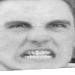

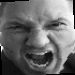

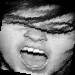

Class: disgust (showing 3)


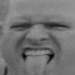

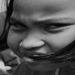

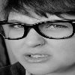

Class: fear (showing 3)


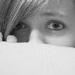

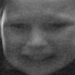

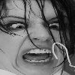

Class: happy (showing 3)


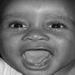

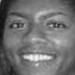

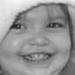

Class: neutral (showing 3)


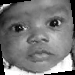

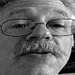

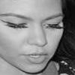

Class: sad (showing 3)


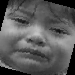

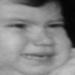

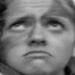

Class: surprise (showing 3)


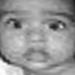

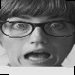

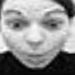

In [3]:
# Preview a few samples per class from the training split
import os, random
from IPython.display import display
from PIL import Image
root = '../data/train'
classes = sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))])
print('Classes:', classes)
samples_per_class = 3
for cls in classes:
    cls_dir = os.path.join(root, cls)
    imgs = [os.path.join(cls_dir, f) for f in os.listdir(cls_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    random.shuffle(imgs)
    print(f'Class: {cls} (showing {min(samples_per_class, len(imgs))})')
    for path in imgs[:samples_per_class]:
        display(Image.open(path))


## 2. Train (ResNet-18, grayscale 1-ch, with imbalance handling)
- Uses weighted sampling and class-weighted CE
- AMP enabled by default (GPU recommended)
- Adjust `--epochs` and `--batch-size` to your hardware

In [4]:
import torch
batch = 256 if torch.cuda.is_available() else 64
epochs = 100
!python ../scripts/train.py \
--data-dir ../data \
--out-dir ../runs/9/2raf \
--epochs {epochs} \
--batch-size {batch} \
--img-size 75 \
--arch resnet18 \
--weighted-sampler \
--class-weighted-ce \
--label-smoothing 0.1

/work/projects/mhahsler/course_recomm/allocation001/AI_Club/projects/mood-recognition-yolo/resnet/src/resnet/train.py:225: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=cfg.amp)
Epoch 1/100 | train 1.3449/56.42 | val 0.8754/69.80 | best 69.80                
              precision    recall  f1-score   support

           0     0.7598    0.7994    0.7791      1072
           1     0.6177    0.5532    0.5837      1072
           2     0.7945    0.8116    0.8030      1072
           3     0.9344    0.6912    0.7946      1072
           4     0.5482    0.6203    0.5821      1072
           5     0.5926    0.6446    0.6175      1072
           6     0.7145    0.7659    0.7393      1072

    accuracy                         0.6980      7504
   macro avg     0.7088    0.6980    0.6999      7504
weighted avg     0.7088    0.6980    0.6999      7504

Epoch 2/100 | train 0.8500/82.32 

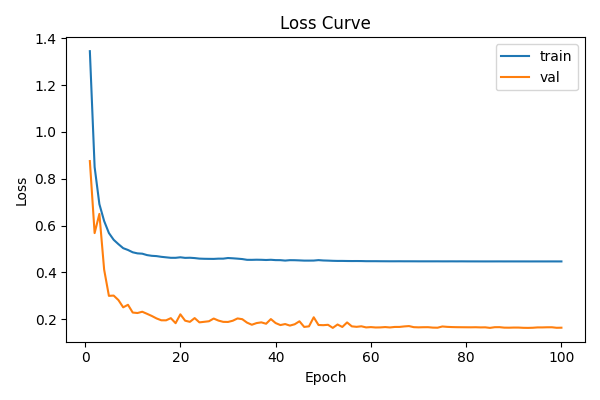

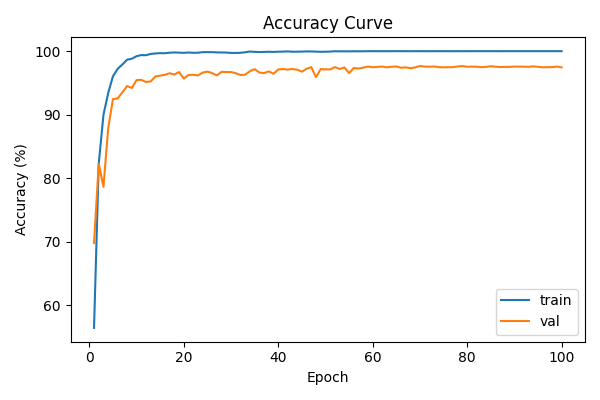

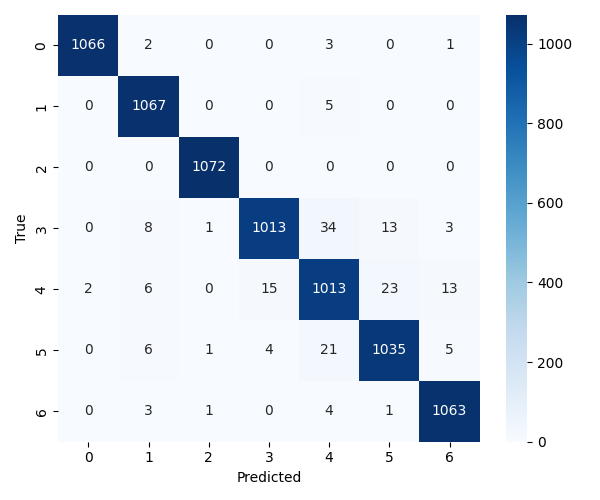

In [9]:
# Display training curves from the run directory
from IPython.display import Image, display
import os
run_dir = '../runs/9/2raf/'
for fname in ['loss_curve.png', 'accuracy_curve.png', 'confusion_matrix_best.png']:
    path = os.path.join(run_dir, fname)
    if os.path.exists(path):
        display(Image(filename=path))

## 3. Evaluate on Validation and Test Splits
Saves confusion matrix and per-class precision/recall charts, plus a CSV of per-class metrics.

In [6]:
!python ../scripts/eval_classification.py --data-dir ../data/val --weights ../runs/9/2raf/best.pt --arch resnet18 --img-size 75
!python ../scripts/eval_classification.py --data-dir ../data/test --weights ../runs/9/2raf/best.pt --arch resnet18 --img-size 75

Eval: 100%|█████████████████████████████████████| 30/30 [00:02<00:00, 14.68it/s]
              precision    recall  f1-score   support

       angry     0.9981    0.9944    0.9963      1072
     disgust     0.9762    0.9953    0.9857      1072
        fear     0.9972    1.0000    0.9986      1072
       happy     0.9816    0.9450    0.9629      1072
     neutral     0.9380    0.9450    0.9414      1072
         sad     0.9664    0.9655    0.9659      1072
    surprise     0.9797    0.9916    0.9856      1072

    accuracy                         0.9767      7504
   macro avg     0.9767    0.9767    0.9766      7504
weighted avg     0.9767    0.9767    0.9766      7504

Eval: 100%|█████████████████████████████████████| 17/17 [00:01<00:00, 16.70it/s]
              precision    recall  f1-score   support

       angry     0.9899    0.9882    0.9891       595
     disgust     0.9801    0.9933    0.9866       595
        fear     0.9950    1.0000    0.9975       595
       happy     0.9807 

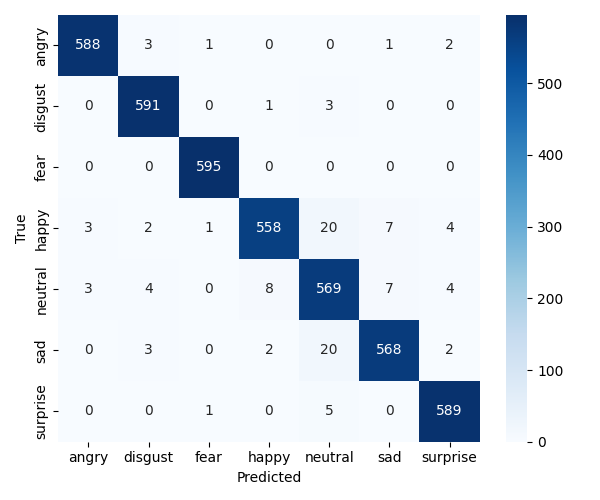

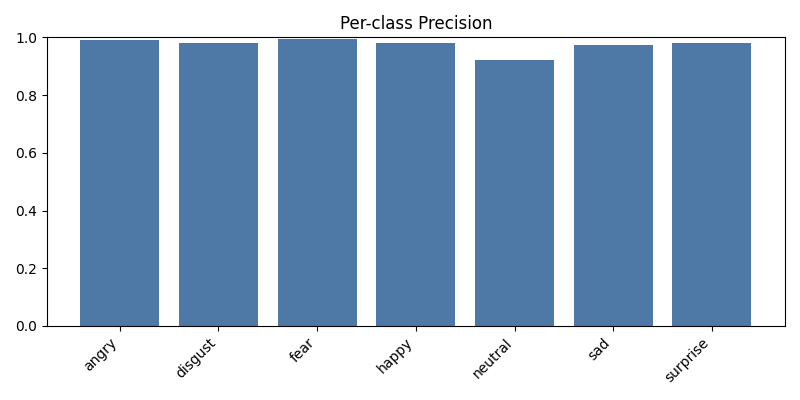

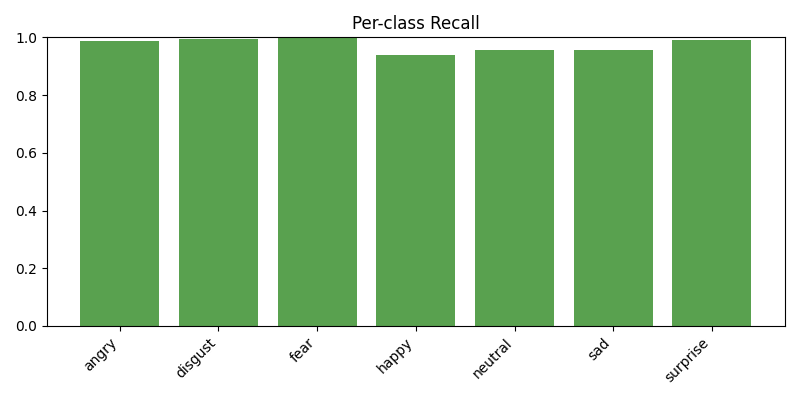

In [7]:
# Display evaluation artifacts inline if present
from IPython.display import Image, display
import os
for fname in ['confusion_matrix.png', 'precision_per_class.png', 'recall_per_class.png']:
    if os.path.exists(fname):
        display(Image(filename=fname))

Outputs in the working directory: 
- `confusion_matrix.png`
- `precision_per_class.png`
- `recall_per_class.png`
- `metrics_per_class.csv`

### Distributed Training (DDP)
Run from a terminal (notebooks are not ideal for multi-process). Example:

`````
CUDA_VISIBLE_DEVICES=0,1 torchrun --standalone --nproc_per_node=2 scripts/train.py \
  --data-dir data --out-dir runs/ddp_fer --epochs 10 --batch-size 256 --img-size 48 --arch resnet18 --weighted-sampler --class-weighted-ce
`````
Artifacts will be saved under `runs/ddp_fer/` on rank 0.


In [8]:
# !CUDA_VISIBLE_DEVICES=0,1 torchrun --standalone --nproc_per_node=2 ../scripts/train.py \
#     --data-dir ../data \
#     --out-dir ../runs/9/1ddp \
#     --epochs 60 \
#     --batch-size 2048 \
#     --img-size 48 \
#     --arch resnet18 \
#     --weighted-sampler \
#     --class-weighted-ce \
#     --label-smoothing 0.1 \

Artifacts are saved under `runs/fer18/`:
- `best.pt`, `last.pt`
- `history.json`, `history.csv`
- `loss_curve.png`, `accuracy_curve.png`
- `confusion_matrix_epoch*.png`, `confusion_matrix_best.png`

## 4. Notes
- Adjust batch size if you run on CPU.
- Training artifacts: check `runs/fer18/`.
- For DDP, prefer a terminal and ensure CUDA is available.
